# Capstone Project - Accident Severity (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data and data preprocessing](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>
### 1.1 Background

In 2018, the United States had roughly 276 million vehicles in operation.  Out of those vehicles, 12 million were involved in crashes.  The United States is also among the countries with the highest rate of traffic-related fatalities per one million population.  

### 1.2 Problem
A lot of these accidents could be prevented if the drivers were more informed about the possible severity of car accident based on different factors. The focus of this project therefore is to predict the severity of an accident, using a number of features. For performance reasons, we will focus our efforts on accidents in the Seattle area, but this will allow us to draw conclusions which are relevant for other areas in the US as well.

### 1.3 Interest
Reliable severity prediction of possible car accidents can help commuters to drive with more foresight or change their travel plans accordingly. In addition, an accident severity prediction system can be interesting for insurance companies in order to prevent possible costs for accidents suffered by their members.

## 2. Data and data preprocessing <a name="data"></a>
### 2.1 Data Source

The dataset was obtained from the [Seattle Department of Transportation website](https://data.seattle.gov/Land-Base/Collisions/9kas-rb8d "Seattle Department of Transportation website"). The data was collected from 2004 to present for the Seattle area. The number of observations in the data is about 220,000 and each observation represents a traffic collision. The original data contains our chosen label, i.e a severity code based on the severity of a collision, where 1 indicates just a property damage and 4 indicates a fatality as highest impact of the collision. It also consists of 39 attributes.

Before we get started loading the dataset, let's import all needed libraries.

**Import needed libraries**

In [62]:
import pandas as pd
import numpy as np
from timezonefinder import TimezoneFinderL
from scipy import stats

# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

#Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

#Import LogisticRegression
from sklearn.linear_model import LogisticRegression

#Import train test split and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

**Load data**

In [63]:
# Read the file
path = "/Users/lauradohle/Box/Laura's Folder/Coursera Data Science Class/Applied Data Science Capstone/Collisions.csv"
df = pd.read_csv(path)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2.2 Data cleaning

There were several steps necessary to clean the dataset and make it usable for the problem statement:

**Drop irrelevant attributes**

First, not all of the attributes in the dataset are relevant for the problem statement. Some are also obvious information duplicates compared to other columns.

Therefore 11 features were removed from the report entirely: 

* OBJECTID, INCKEY, SDOTCOLNUM and COLDETKEY were just different variations of unique identifiers, not important to the problem statement at hand.
* SDOT_COLDESC was a description of the collision, that directly duplicated the information given via SDOT_COLCODE. 
* ST_COLDESC was a description of the collision, that directly duplicated the information given via ST_COLCODE.
* EXCEPTRSNCODE and EXCEPTRSNDESC was not described in the metadata and also only consisted of different forms of missing data.
* INCDATE was a duplicate of information also present in INCDTTM.
* STATUS and REPORTNO we removed since it they were not described in the metadata.

This left us with 28 attributes still present in the dataset.

In [64]:
#drop the columns not relevant to our problem statement

df_new=df.drop(columns=['OBJECTID', 'INCKEY','COLDETKEY', 'SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLDESC', 'REPORTNO', 'STATUS', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INCDATE'])


**Change columns to correct data format**

The next step in data cleaning was to check and make sure that all data was in the correct format (int, float, text or other).

In [65]:
#Check data formats
df_new.dtypes

X                  float64
Y                  float64
ADDRTYPE            object
INTKEY             float64
LOCATION            object
SEVERITYCODE        object
SEVERITYDESC        object
COLLISIONTYPE       object
PERSONCOUNT          int64
PEDCOUNT             int64
PEDCYLCOUNT          int64
VEHCOUNT             int64
INJURIES             int64
SERIOUSINJURIES      int64
FATALITIES           int64
INCDTTM             object
JUNCTIONTYPE        object
SDOT_COLCODE       float64
INATTENTIONIND      object
UNDERINFL           object
WEATHER             object
ROADCOND            object
LIGHTCOND           object
PEDROWNOTGRNT       object
SPEEDING            object
ST_COLCODE          object
SEGLANEKEY           int64
CROSSWALKKEY         int64
HITPARKEDCAR        object
dtype: object

As we can see above, some columns are not of the correct data type: 
* The multiclass categorical data of 'SDOT_COLCODE' needs to have type 'str' (object).
* The Boolean values 'INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR' need to be changed to numeric values 0/1 instead of True/False and therefore be of type 'float' or 'int' to make them more usable for the machine learning section later on. 
* Also, 'INCDTTM' needs to be converted to the datatype 'datetime'.

While having a closer look at those attributes, let's also make sure to clean them of any duplicate or missing values.

In [66]:
#Convert SDOT_COLCODE to type 'str'
df_new[['SDOT_COLCODE']] = df_new[['SDOT_COLCODE']].astype('str')

#Check for NaN values
df_new['SDOT_COLCODE'].value_counts(dropna=False)

11.0    92089
14.0    59300
0.0     19158
16.0    10935
28.0     9599
24.0     7694
13.0     6887
26.0     5072
18.0     3434
15.0     1820
12.0     1781
51.0     1472
29.0      559
21.0      207
56.0      199
27.0      173
54.0      153
23.0      129
48.0      119
31.0      111
25.0      110
34.0      100
64.0       98
69.0       86
33.0       57
55.0       56
66.0       31
22.0       19
44.0       16
32.0       13
53.0        9
61.0        7
58.0        6
35.0        6
68.0        6
46.0        4
36.0        4
52.0        2
47.0        2
nan         1
87.0        1
Name: SDOT_COLCODE, dtype: int64

SDOT_COLCODE has one NaN value that we can drop.

In [67]:
#get list of index with NaN values for SDOT_COLCODE attribute
index_SDOT=df_new.loc[pd.isna(df_new["SDOT_COLCODE"]), :].index

#drop the rows with NaN values for ST_COLCODE attributes 
for i in index_SDOT:
    df_new.drop(index_SDOT, inplace=True)

Boolean attributes that have to be converted:

In [68]:
#Check for NaN values or duplicate values
df_new['INATTENTIONIND'].value_counts(dropna=False)

NaN    191337
Y       30188
Name: INATTENTIONIND, dtype: int64

In [69]:
#Check for NaN values or duplicate values
df_new['UNDERINFL'].value_counts(dropna=False)

N      103927
0       81676
NaN     26293
Y        5399
1        4230
Name: UNDERINFL, dtype: int64

In [70]:
#Check for NaN values or duplicate values
df_new['PEDROWNOTGRNT'].value_counts(dropna=False)

NaN    216330
Y        5195
Name: PEDROWNOTGRNT, dtype: int64

In [71]:
#Check for NaN values or duplicate values
df_new['SPEEDING'].value_counts(dropna=False)

NaN    211596
Y        9929
Name: SPEEDING, dtype: int64

In [72]:
#Check for NaN values or duplicate values
df_new['HITPARKEDCAR'].value_counts(dropna=False)

N    209492
Y     12033
Name: HITPARKEDCAR, dtype: int64

For the attributes INATTENTIONIND, SPEEDING and PEDROWNOTGRNT people only entered 'Y' or did not enter anything at all, instead of entering 'N'. For those three attributes we will replace the 'Y' values with 1 and the NaN values with 0 and turn the dtype into float, to make them usable for the machine learning model later on.

In [73]:
#Convert True/False values to 1/0
df_new[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING']] = df_new[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING']].replace({'Y': 1})
df_new[['HITPARKEDCAR']] = df_new[['HITPARKEDCAR']].replace({'Y': 1, 'N': 0})

In [74]:
#Fill NaN values with 0
df_new[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING']] = df_new[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING']].fillna(0)

#Convert boolean values to type 'float64'
df_new[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING']] = df_new[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING']].astype('float64')

For the attribute 'UNDERINFL' there is a mix between numeric and string boolean values, as well as some missing values. We will convert the 'Y' values into 1 and the 'N' values into 0 before having a closer look at the NaN values.

In [75]:
#Convert True/False values to 1/0
df_new[['UNDERINFL']] = df_new[['UNDERINFL']].replace({'Y': 1, 'N':0})

Due to the fact that, if we look at the other boolean values that indicate a contributing factor to the accident, the number of TRUE(1) values is roughly between 2-15% and we already have 5% TRUE values for the 'UNDERINFL' attribute, we will count the NaN values as FALSE(0).

In [76]:
df_new[['UNDERINFL']] = df_new[['UNDERINFL']].fillna(0)

In [77]:
#Convert boolean value to type 'float64'
df_new[['UNDERINFL']] = df_new[['UNDERINFL']].astype('float64')

Finally, let's change the attribute 'INCDTTM' to a datetime type and check for any possible missing values:

In [78]:
#Convert date and time values to type 'datetime64'
df_new[['INCDTTM']]=df_new[['INCDTTM']].astype('datetime64')

#Check for NaN values
df_new['INCDTTM'].isna().sum()

0

**Split date and time attribute**

Time attributes might be very relevant when trying to predict accident severity. For example, there might be larger severity accidents during rush hour when people are commuting than during general working hours. That is why it makes sense to split the Datetime attribute into smaller increments.

In [79]:
# Extract year, month, day, hour and weekday
df_new['YEAR']=df_new['INCDTTM'].dt.year
df_new['MONTH']=df_new['INCDTTM'].dt.strftime('%b')
df_new['DAY']=df_new['INCDTTM'].dt.day
df_new['HOUR']=df_new['INCDTTM'].dt.hour
df_new['WEEKDAY']=df_new['INCDTTM'].dt.strftime('%a')


In [80]:
#Check if the new attributes are in the correct format
df_new.dtypes

X                         float64
Y                         float64
ADDRTYPE                   object
INTKEY                    float64
LOCATION                   object
SEVERITYCODE               object
SEVERITYDESC               object
COLLISIONTYPE              object
PERSONCOUNT                 int64
PEDCOUNT                    int64
PEDCYLCOUNT                 int64
VEHCOUNT                    int64
INJURIES                    int64
SERIOUSINJURIES             int64
FATALITIES                  int64
INCDTTM            datetime64[ns]
JUNCTIONTYPE               object
SDOT_COLCODE               object
INATTENTIONIND            float64
UNDERINFL                 float64
WEATHER                    object
ROADCOND                   object
LIGHTCOND                  object
PEDROWNOTGRNT             float64
SPEEDING                  float64
ST_COLCODE                 object
SEGLANEKEY                  int64
CROSSWALKKEY                int64
HITPARKEDCAR                int64
YEAR          

Now that we split the relevant time data into different attributes we can drop the original time attribute.

In [81]:
df_new=df_new.drop(columns=['INCDTTM'])

**Clean remaining categorical data**

Before we continue with identifying and handling missing values, let's have a look at the categorical data we have not looked at yet to see if it needs some additional grouping and cleaning.

We have ten categorical data attributes (excluding boolean) and one categorical label we need to inspect:

<ul>
   <li>1. "ADDRTYPE"</li>
   <li>2. "JUNCTIONTYPE"</li>
   <li>3. "ST_COLCODE"</li>    
   <li>4. "COLLISIONTYPE"</li>
   <li>5. "WEATHER"</li>
   <li>6. "ROADCOND"</li>
   <li>7. "LIGHTCOND"</li>
   <li>8. "SEGLANEKEY"</li>
   <li>9. "CROSSWALKKEY"</li>
   <li>10. "SEVERITYDESC"</li>
   <li>11. Label:"SEVERITYCODE"</li>
</ul>

Let's go through each of them to see if they need to be cleaned.

**1 ADDRTYPE**

In [82]:
#Check for missing or duplicate values
df_new['ADDRTYPE'].value_counts(dropna=False)

Block           144999
Intersection     71936
NaN               3712
Alley              878
Name: ADDRTYPE, dtype: int64

We can actually tell if a ADDRTYPE is a Block, Intersection or Alley by looking at the LOCATION attribute, as they are very related:

* For Blocks the phrasing of the LOCATION is: "X BETWEEN Y AND Z"
* For Intersections the phrasing of LOCATION is: "X AND Y"
* For Alleys the LOCATION always has a NaN value, while LOCATION never has a NaN value for ADDRTYPE Block or Intersection.


If we look at the rows with ADDRTYPE NaN, all of them also have LOCATION NaN. Because LOCATION NaN always mean Alley we will assign them as Alleys.

In [83]:
#Assign missing values the value 'Alley'
df_new[['ADDRTYPE']] = df_new[['ADDRTYPE']].fillna('Alley')

**2 JUNCTIONTYPE**

In [84]:
#Check for missing or duplicate values
df_new['JUNCTIONTYPE'].value_counts(dropna=False)

Mid-Block (not related to intersection)              101709
At Intersection (intersection related)                69228
Mid-Block (but intersection related)                  24410
NaN                                                   11974
Driveway Junction                                     11496
At Intersection (but not related to intersection)      2497
Ramp Junction                                           190
Unknown                                                  21
Name: JUNCTIONTYPE, dtype: int64

JUNCTIONTYPE has two different types of missing values: Unknown and NaN. We will replace Unknown with NaN.

In [85]:
# replace "unknown" to NaN
df_new['JUNCTIONTYPE'].replace("Unknown", np.nan, inplace = True)

46% of all accidents happen Mid-Block (not related to intersection). That is why we replace missing values with 'Mid-Block (not related to intersection)' as the most frequent.

In [86]:
#Replace missing values with most frequent value
df_new['JUNCTIONTYPE'] = df_new['JUNCTIONTYPE'].fillna('Mid-Block (not related to intersection)')

**3 ST_COLCODE**

In [87]:
#Check for missing or duplicate values
df_new['ST_COLCODE'].isna().sum()

9413

The missing vales for ST_COLCODE cannot realistically be replaced with other data. We will therefore drop the rows missing data.

In [89]:
#get list of index with NaN values for ST_COLCODE attribute
index_list=df_new.loc[pd.isna(df_new["ST_COLCODE"]), :].index

#drop the rows with NaN values for ST_COLCODE attributes 
for i in index_list:
    df_new.drop(index_list, inplace=True)

**4 COLLISIONTYPE**

In [90]:
#Check for missing or duplicate values
df_new['COLLISIONTYPE'].value_counts(dropna=False)

Parked Car    48551
Angles        35573
Rear Ended    34691
Other         24588
Sideswipe     18891
NaN           16900
Left Turn     14115
Pedestrian     7666
Cycles         5932
Right Turn     3017
Head On        2188
Name: COLLISIONTYPE, dtype: int64

We can derive the missing COLLISIONTYPE values by taking them from the descriptions of ST_COLCODE for each row.

In [91]:
#Replace NaN values for COLLISIONTYPE by taking them from the descriptions of ST_COLCODE for each row and matching those values to categories fro COLLISIONTYPE.

index_coll=df_new.loc[pd.isna(df_new['COLLISIONTYPE']), :].index

pedestrian=['0','1','2','3','4','5']
angles=['10']
sideswipe=['11','12','26','27','71','72','81','82']
rear_ended=['13','14','83','84','73','74']
left_turn=['15','28','29']
right_turn=['16']
parked_car=['19','20','32']
other=['21','22','23','31','40','41','42','43','47','48','49','50','51','52','53','54','55','56','57','58','59','60','61','62','63','64','65','66','67']
head_on=['24','25','30']
cycles=['44','45','46']

for i in index_coll:
    if df_new.loc[i, 'ST_COLCODE'] in pedestrian:
        df_new.loc[i,'COLLISIONTYPE'] = 'Pedestrian'
    elif df_new.loc[i, 'ST_COLCODE'] in angles:
        df_new.loc[i,'COLLISIONTYPE'] = 'Angles'
    elif df_new.loc[i, 'ST_COLCODE'] in sideswipe:
        df_new.loc[i,'COLLISIONTYPE'] = 'Sideswipe'
    elif df_new.loc[i, 'ST_COLCODE'] in rear_ended:
        df_new.loc[i,'COLLISIONTYPE'] = 'Rear Ended'
    elif df_new.loc[i, 'ST_COLCODE'] in left_turn:
        df_new.loc[i,'COLLISIONTYPE'] = 'Left Turn'
    elif df_new.loc[i, 'ST_COLCODE'] in right_turn:
        df_new.loc[i,'COLLISIONTYPE'] = 'Right Turn'
    elif df_new.loc[i, 'ST_COLCODE'] in parked_car:
        df_new.loc[i,'COLLISIONTYPE'] = 'Parked Car'
    elif df_new.loc[i, 'ST_COLCODE'] in other:
        df_new.loc[i,'COLLISIONTYPE'] = 'Other'    
    elif df_new.loc[i, 'ST_COLCODE'] in head_on:
        df_new.loc[i,'COLLISIONTYPE'] = 'Head On'
    else: 
        df_new.loc[i,'COLLISIONTYPE'] = 'Cycles'

**5 WEATHER**

In [92]:
#Check for missing or duplicate values
df_new['WEATHER'].value_counts(dropna=False)

Clear                       114733
Raining                      34029
Overcast                     28545
NaN                          17109
Unknown                      15131
Snowing                        919
Other                          860
Fog/Smog/Smoke                 577
Sleet/Hail/Freezing Rain       116
Blowing Sand/Dirt               56
Severe Crosswind                26
Partly Cloudy                   10
Blowing Snow                     1
Name: WEATHER, dtype: int64

WEATHER has two different types of missing values: Unknown and NaN. We will replace Unknown with NaN.

In [93]:
# replace "unknown" to NaN
df_new['WEATHER'].replace("Unknown", np.nan, inplace = True)

Almost 60% of all accidents happen in clear weather. That is why we replace missing values with 'Clear' as the most frequent.

In [94]:
#Replace missing values with most frequent value
df_new['WEATHER'] = df_new['WEATHER'].fillna('Clear')

**6 ROADCOND**

In [95]:
#Check for missing or duplicate values
df_new['ROADCOND'].value_counts(dropna=False)

Dry               128583
Wet                48723
NaN                17028
Unknown            15137
Ice                 1231
Snow/Slush          1014
Other                136
Standing Water       119
Sand/Mud/Dirt         77
Oil                   64
Name: ROADCOND, dtype: int64

ROADCOND also has two different types of missing values: Unknown and NaN. We will replace Unknown with NaN.

In [96]:
# replace "unknown" to NaN
df_new['ROADCOND'].replace("Unknown", np.nan, inplace = True)

Almost 60% of all accidents happen on dry road. That is why we replace missing values with 'Dry' as the most frequent.

In [97]:
#Replace missing values with most frequent value
df_new['ROADCOND'] = df_new['ROADCOND'].fillna('Dry')

**7 LIGHTCOND**

In [98]:
#Check for missing or duplicate values
df_new['LIGHTCOND'].value_counts(dropna=False)

Daylight                    119479
Dark - Street Lights On      50130
NaN                          17198
Unknown                      13532
Dusk                          6081
Dawn                          2608
Dark - No Street Lights       1578
Dark - Street Lights Off      1239
Other                          244
Dark - Unknown Lighting         23
Name: LIGHTCOND, dtype: int64

LIGHTCOND also has two different types of missing values: Unknown and NaN. We will replace Unknown with NaN.

In [99]:
# replace "unknown" to NaN
df_new['LIGHTCOND'].replace("Unknown", np.nan, inplace = True)

We can derive the missing values for LIGHTCOND with a combination of MONTH and HOUR data.  We can at least tell wheather it was dark or light outside for Seattle.


In [100]:
light_data = {'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 'Day(Hour)': [8,7,6,6,5,5,4,5,6,6,6,7], 'Night(Hour)': [17,17,18,20,21,21,22,21,20,19,17,17]}
seattle_light = pd.DataFrame(data=light_data)
seattle_light

,Month,Day(Hour),Night(Hour)
0,Jan,8,17
1,Feb,7,17
2,Mar,6,18
3,Apr,6,20
4,May,5,21
5,Jun,5,21
6,Jul,4,22
7,Aug,5,21
8,Sep,6,20
9,Oct,6,19


In [101]:
#Replace NaN values for LIGHTCOND with either Daylight or Dark - Unknown Lighting

index_light=df_new.loc[pd.isna(df_new['LIGHTCOND']), :].index

for i in index_light:
    if (df_new.loc[i,'MONTH'] == 'Jan') & (df_new.loc[i,'HOUR'] >=8) & (df_new.loc[i,'HOUR'] <=17) or (df_new.loc[i,'MONTH'] == 'Feb') & (df_new.loc[i,'HOUR'] >=7) & (df_new.loc[i,'HOUR'] <=17) or (df_new.loc[i,'MONTH'] == 'Mar') & (df_new.loc[i,'HOUR'] >=6) & (df_new.loc[i,'HOUR'] <=18) or (df_new.loc[i,'MONTH'] == 'Apr') & (df_new.loc[i,'HOUR'] >=6) & (df_new.loc[i,'HOUR'] <=20) or (df_new.loc[i,'MONTH'] == 'May') & (df_new.loc[i,'HOUR'] >=5) & (df_new.loc[i,'HOUR'] <=21) or (df_new.loc[i,'MONTH'] == 'Jun') & (df_new.loc[i,'HOUR'] >=5) & (df_new.loc[i,'HOUR'] <=21) or (df_new.loc[i,'MONTH'] == 'Jul') & (df_new.loc[i,'HOUR'] >=4) & (df_new.loc[i,'HOUR'] <=22) or (df_new.loc[i,'MONTH'] == 'Aug') & (df_new.loc[i,'HOUR'] >=5) & (df_new.loc[i,'HOUR'] <=21) or (df_new.loc[i,'MONTH'] == 'Sep') & (df_new.loc[i,'HOUR'] >=6) & (df_new.loc[i,'HOUR'] <=20) or (df_new.loc[i,'MONTH'] == 'Oct') & (df_new.loc[i,'HOUR'] >=6) & (df_new.loc[i,'HOUR'] <=19) or (df_new.loc[i,'MONTH'] == 'Nov') & (df_new.loc[i,'HOUR'] >=6) & (df_new.loc[i,'HOUR'] <=17) or (df_new.loc[i,'MONTH'] == 'Dec') & (df_new.loc[i,'HOUR'] >=7) & (df_new.loc[i,'HOUR'] <=17) :
        df_new.loc[i,'LIGHTCOND'] = 'Daylight'
    else:
        df_new.loc[i,'LIGHTCOND'] = 'Dark - Unknown Lighting'

**8 SEGLANEKEY**

In [102]:
#Check for missing or duplicate values
df_new['SEGLANEKEY'].value_counts(dropna=False)

0        209095
6532         19
6078         19
12162        18
10336        15
          ...  
6848          1
41943         1
15428         1
7360          1
16376         1
Name: SEGLANEKEY, Length: 2091, dtype: int64

SEGLANEKEY is mainly consists of 0 as a key, which is most likely a missing value, that cannot be replaced because of the high number of missing values. We should therefore drop SEGLANEKEY entirely.

In [103]:
#drop column
df_new=df_new.drop(columns=['SEGLANEKEY'])

**9 CROSSWALKKEY**

In [104]:
#Check for missing or duplicate values
df_new['CROSSWALKKEY'].value_counts(dropna=False)

0         207870
523609        19
520838        15
524265        13
525567        13
           ...  
525111         1
523080         1
521033         1
523208         1
521927         1
Name: CROSSWALKKEY, Length: 2343, dtype: int64

CROSSWALKKEY is mainly consists of 0 as a key, which is most likely a missing value, that cannot be replaced because of the high number of missing values. We should therefore drop CROSSWALKKEY entirely.

In [105]:
#drop column
df_new=df_new.drop(columns=['CROSSWALKKEY'])

**10 SEVERITYDESC**

In [106]:
#Check for missing or duplicate values
df_new['SEVERITYDESC'].value_counts(dropna=False)

Property Damage Only Collision    137666
Injury Collision                   58770
Unknown                            12221
Serious Injury Collision            3105
Fatality Collision                   350
Name: SEVERITYDESC, dtype: int64

SEVERITYDESC has one type of missing value: Unknown. First we need to change Unknown to NaN.

In [107]:
# replace "unknown" to NaN
df_new['SEVERITYDESC'].replace("Unknown", np.nan, inplace = True)

We can now assign the correct SEVERITYDESC to the rows missing data by combining the SEVERITYDESC with INJURIES, SERIOUSINJURIES and FATALITIES. But first, let's have a look at INJURIES, SERIOUSINJURIES and FATALITIES to see if they need cleaning ahead of us replacing the missing values of SEVERITYCODE.

In [108]:
#Are there cases where they are not mutually exclusive?

mut_ex=df_new[(df_new['INJURIES'] > 0) & (df_new['SERIOUSINJURIES'] > 0) & (df_new['FATALITIES'] > 0)]
mut_ex.head()

,X,Y,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,...,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR,YEAR,MONTH,DAY,HOUR,WEEKDAY
1970,1.253323e+06,251958.909174,Block,NaN,SEAVIEW AVE NW BETWEEN NW 67TH ST AND NW 75TH ST,3,Fatality Collision,Left Turn,2,0,...,Daylight,0.0,0.0,28,0,2018,Aug,14,9,Tue
9208,1.285370e+06,200056.861441,Block,NaN,RAINIER AVE S BETWEEN S FRONTENAC ST AND S MYR...,3,Fatality Collision,Sideswipe,7,0,...,Dark - Street Lights On,0.0,1.0,11,0,2004,Aug,15,21,Sun
20567,1.268574e+06,214736.772112,Block,NaN,EAST MARGINAL WAY S BETWEEN S STACY ST AND S H...,3,Fatality Collision,Other,4,0,...,Dark - Street Lights On,0.0,0.0,50,0,2005,Mar,4,0,Fri
20716,1.274853e+06,251502.760886,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 70TH ST AND NE 71S...,3,Fatality Collision,Other,6,0,...,Dark - Street Lights On,0.0,1.0,50,0,2005,Nov,10,23,Thu
23149,1.268255e+06,255550.050490,Intersection,37367.0,AURORA AVE N AND N 85TH ST,3,Fatality Collision,Angles,3,0,...,Daylight,0.0,0.0,10,0,2005,May,26,10,Thu


We can see that INJURIES, SERIOUSINJURIES and FATALITIES are not mutually exclusive. This might pose a problem when we want to use those attributes to create the missing values for SEVERITYDESC.

We can solve this by combining multiple conditions for the values of INJURIES, SERIOUSINJURIES and FATALITIES, that allows us to only consider the maximum mentioned damage for SEVERITYDESC, ranking property damage, injury, serious injury and fatality.

In [109]:
#Replace NaN values for SEVERITYDESC

index_sevdesc=df_new.loc[pd.isna(df_new['SEVERITYDESC']), :].index

for i in index_sevdesc:
    if (df_new.loc[i, 'INJURIES']>0) and not (((df_new.loc[i, 'SERIOUSINJURIES']>0) and (df_new.loc[i, 'FATALITIES']>0)) or (df_new.loc[i, 'SERIOUSINJURIES']>0) or (df_new.loc[i, 'FATALITIES']>0)):
        df_new.loc[i,'SEVERITYDESC'] = 'Injury Collision'
    elif (df_new.loc[i, 'SERIOUSINJURIES']>0) and not (df_new.loc[i, 'FATALITIES']>0):
        df_new.loc[i,'SEVERITYDESC'] = 'Serious Injury Collision'
    elif df_new.loc[i, 'FATALITIES']>0:
        df_new.loc[i,'SEVERITYDESC'] = 'Fatality Collision'
    else: 
        df_new.loc[i,'SEVERITYDESC'] = 'Property Damage Only Collision'

**11 Label: SEVERITYCODE**

In [110]:
#Check for missing or duplicate values
df_new['SEVERITYCODE'].value_counts(dropna=False)

1     137666
2      58770
0      12221
2b      3105
3        350
Name: SEVERITYCODE, dtype: int64

SEVERITYCODE also has two different types of missing values: 0(Unknown) and NaN. First, we will replace 0(Unknown) with NaN.

In [111]:
# replace "0" to NaN
df_new['SEVERITYCODE'].replace("0", np.nan, inplace = True)

We can assign the correct SEVERITYCODE to the rows missing data by combining the SEVERITYCODE with SEVERITYDESC.

In [112]:
#Replace NaN values for SEVERITYCODE

index_sev=df_new.loc[pd.isna(df_new['SEVERITYCODE']), :].index

for i in index_sev:
    if df_new.loc[i, 'SEVERITYDESC']=='Injury Collision':
        df_new.loc[i,'SEVERITYCODE'] = '2'
    elif df_new.loc[i, 'SEVERITYDESC']=='Serious Injury Collision':
        df_new.loc[i,'SEVERITYCODE'] = '2b'
    elif df_new.loc[i, 'SEVERITYDESC']=='Fatality Collision':
        df_new.loc[i,'SEVERITYCODE'] = '3'
    else: 
        df_new.loc[i,'SEVERITYCODE'] = '1'

For better output during the data exploration phase, let's also change the values of SEVERITYCODE to a numerical sequence from 0-3 rather than 1, 2, 2b, 3.

In [113]:
#Convert 1, 2, 2b, 3 values to 0, 1, 2, 3
df_new[['SEVERITYCODE']] = df_new[['SEVERITYCODE']].replace({'1': '0', '2': '1', '2b': '2', '3': '3'})

Finally, let's change SEVERITYCODE from object to integer type.

In [114]:
#Convert SEVERITYCODE values to type 'int64'
df_new[['SEVERITYCODE']]=df_new[['SEVERITYCODE']].astype('int64')

**Identify and handle remaining missing values**


In [115]:
#Identify missing values
missing_data = df_new.isnull()
missing_data.head(5)

,X,Y,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,...,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR,YEAR,MONTH,DAY,HOUR,WEEKDAY
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Using a for loop, we can figure out the number of missing values in each column. "True" represents a missing value, "False" means the value is present in the dataset.

In [116]:
#Count missing values in each column
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")   

X
False    205448
True       6664
Name: X, dtype: int64

Y
False    205448
True       6664
Name: Y, dtype: int64

ADDRTYPE
False    212112
Name: ADDRTYPE, dtype: int64

INTKEY
True     142758
False     69354
Name: INTKEY, dtype: int64

LOCATION
False    208202
True       3910
Name: LOCATION, dtype: int64

SEVERITYCODE
False    212112
Name: SEVERITYCODE, dtype: int64

SEVERITYDESC
False    212112
Name: SEVERITYDESC, dtype: int64

COLLISIONTYPE
False    212112
Name: COLLISIONTYPE, dtype: int64

PERSONCOUNT
False    212112
Name: PERSONCOUNT, dtype: int64

PEDCOUNT
False    212112
Name: PEDCOUNT, dtype: int64

PEDCYLCOUNT
False    212112
Name: PEDCYLCOUNT, dtype: int64

VEHCOUNT
False    212112
Name: VEHCOUNT, dtype: int64

INJURIES
False    212112
Name: INJURIES, dtype: int64

SERIOUSINJURIES
False    212112
Name: SERIOUSINJURIES, dtype: int64

FATALITIES
False    212112
Name: FATALITIES, dtype: int64

JUNCTIONTYPE
False    212112
Name: JUNCTIONTYPE, dtype: int64

SDOT_COLCODE
False    21

Based on the summary above, each column has 212,112 rows of data, with 4 columns containing missing data:
<ol>
    <li>"X": 6664 missing data points</li>
    <li>"Y": 6664 missing data points</li>
    <li>"INTKEY": 142758 missing data points</li>
    <li>"LOCATION": 3910 missing data points</li>  
</ol>

**Handle missing values**

Whole columns should be dropped only if most entries in the column are empty.
In our dataset, INTKEY has enough missing values to drop entirely (~67%).
We can also drop whole columns for X, Y and Location. They have a lot of missing values we cannot realistically retrieve from other sources and aren't really necessary to predict severity.

In [117]:
#drop columns

df_new=df_new.drop(columns=['X', 'Y', 'LOCATION', 'INTKEY'])

Let's do one final check to see if we got rid of all missing data values.

In [118]:
missing_data_check = df_new.isnull()
missing_data_check.head(5)

,ADDRTYPE,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,...,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR,YEAR,MONTH,DAY,HOUR,WEEKDAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [119]:
for column in missing_data_check.columns.values.tolist():
    print(column)
    print (missing_data_check[column].value_counts())
    print("")   

ADDRTYPE
False    212112
Name: ADDRTYPE, dtype: int64

SEVERITYCODE
False    212112
Name: SEVERITYCODE, dtype: int64

SEVERITYDESC
False    212112
Name: SEVERITYDESC, dtype: int64

COLLISIONTYPE
False    212112
Name: COLLISIONTYPE, dtype: int64

PERSONCOUNT
False    212112
Name: PERSONCOUNT, dtype: int64

PEDCOUNT
False    212112
Name: PEDCOUNT, dtype: int64

PEDCYLCOUNT
False    212112
Name: PEDCYLCOUNT, dtype: int64

VEHCOUNT
False    212112
Name: VEHCOUNT, dtype: int64

INJURIES
False    212112
Name: INJURIES, dtype: int64

SERIOUSINJURIES
False    212112
Name: SERIOUSINJURIES, dtype: int64

FATALITIES
False    212112
Name: FATALITIES, dtype: int64

JUNCTIONTYPE
False    212112
Name: JUNCTIONTYPE, dtype: int64

SDOT_COLCODE
False    212112
Name: SDOT_COLCODE, dtype: int64

INATTENTIONIND
False    212112
Name: INATTENTIONIND, dtype: int64

UNDERINFL
False    212112
Name: UNDERINFL, dtype: int64

WEATHER
False    212112
Name: WEATHER, dtype: int64

ROADCOND
False    212112
Name: ROADC

All NaN values now have been removed and we still have 212,112 individual accident events.

### 2.3 Feature selection

After data cleaning, there were 212,112 samples and 26 attributes in the data. Upon examining each attribute, it was clear that there was some further redundancy. 

ST_COLCODE indicates the type of collision and is therefore almost identical with COLLISIONTYPE, so I decided to drop ST_COLCODE.

SEVERITYDESC is the more detailed description version of SEVERITYCODE. I therefore decided to drop SEVERITYDESC to decrease redundancy.

After all, 24 features were selected for data exploration.



In [120]:
#drop SEVERITYDESC and ST_COLCODE

df_cleaned=df_new.drop(columns=['SEVERITYDESC', 'ST_COLCODE'])

## 3. Methodology <a name="methodology"></a>

In this project we will try to predict the severity of an accident in the Seattle area based on different predictor features.

In our first step we have collected a suitable database that includes accident severity as a label and a number of additional attributes that could serve as predictor features potentially. 

Our second step was to cleaned and wrangled the dataset: 
<li>Obviously irrelevant features have been dismissed</li>
<li>Categorical data has been cleaned</li>
<li>Features containing any missing data points have been cleaned and dropped if necessary</li>

The next step in our analysis will be the exploration of the relationship between SEVERITYCODE and our potential predictor features to get a better understanding of possible good candidates for features in our ML models. After finishing the data exploration we will drop features which do not serve as good predictor attributes for SEVERITYCODE.

We will then go ahead and preprocess the remaining data for our ML models by turning categorical data into numerical data and splitting our data set into training and testing data.

Lastly, we will try ML different models and decide which one is the most suitable for the task.


### 3.1 Explorative analysis
**Relationship between Severity and the numerical attributes**

In total, there are 7 numerical attributes where we need to explore the relationship to SEVERITYCODE further:
* 1 PERSONCOUNT
* 2 PEDCOUNT
* 3 PEDCYLCOUNT
* 4 VEHCOUNT
* 5 INJURIES
* 6 SERIOUSINJURIES
* 7 FATALITIES

For the numerical attributes in our data set I decided to use a scatterplot visualization and the Kendall’s rank coefficient combined with the p value for quantitative analysis.

The Kendall’s rank coefficient allows the comparison of columns of ranked data. A value close to 0 means no relationship and values close to 1 mean a perfect relationship. The test can also produce negative values, but they can just be treated like positive values.

**1 Relationship between SEVERITYCODE and PERSONCOUNT**

[(-0.7320677109467547, 4)]

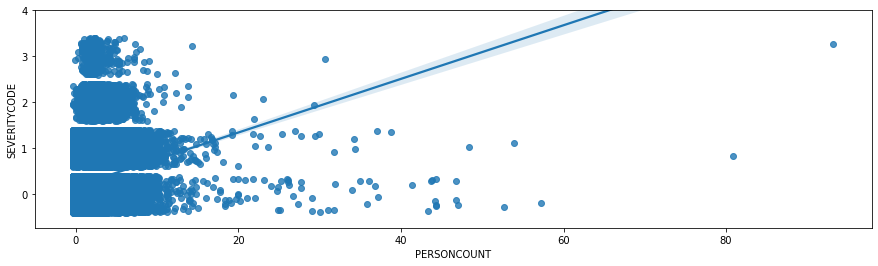

In [121]:
plt.figure(figsize=(15,4))

pc=sns.regplot(x="PERSONCOUNT", y="SEVERITYCODE", data=df_cleaned, x_jitter=.4, y_jitter=.4)
pc.set(ylim=(None,4))

The regression line is almost horizontal and the data points are very far from the fitted line. Therefore it might not be a reliable variable.

In [122]:
tau, p_value = stats.kendalltau(df_cleaned["PERSONCOUNT"], df_cleaned["SEVERITYCODE"])
print(tau)
print(p_value)

0.17642911978677406
0.0


**Conclusion**

<p>Since the p-value is $<$ 0.001, the correlation between PERSONCOUNT and SEVERITYCODE is statistically significant, although the linear relationship is weak (~0.176)</p>

***=> PERSONCOUNT is not a good predictor of SEVERITYCODE.***

**2 Relationship between SEVERITYCODE and PEDCOUNT**

[(-0.6666749598745598, 4)]

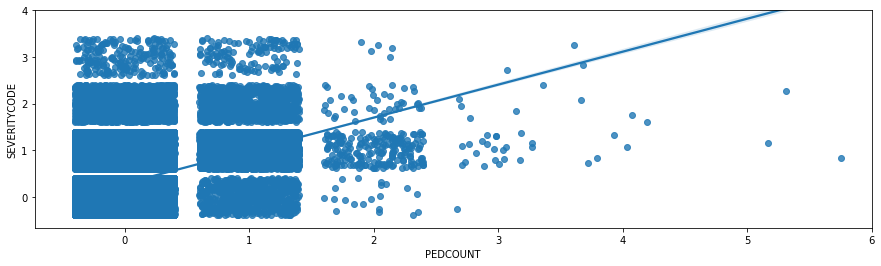

In [123]:
plt.figure(figsize=(15,4))

pc=sns.regplot(x="PEDCOUNT", y="SEVERITYCODE", data=df_cleaned, x_jitter=.4, y_jitter=.4)
pc.set(ylim=(None,4))

<p>Even though the regression line is almost a perfect diagonal, the data points are very far from the fitted line. Therefore PERSONCOUNT does not seem to be a reliable variable.</p>

In [124]:
tau, p_value = stats.kendalltau(df_cleaned["PEDCOUNT"], df_cleaned["SEVERITYCODE"])
print(tau)
print(p_value)

0.277642648139243
0.0


**Conclusion**

<p>Since the p-value is $<$ 0.001, the correlation between PEDCOUNT and SEVERITYCODE is statistically significant, although the linear relationship is weak (~0.278)</p>

***=> PEDCOUNT is not a good predictor of SEVERITYCODE.***

**3 Relationship between SEVERITYCODE and PEDCYLCOUNT**

[(-0.6065326702988574, 4),

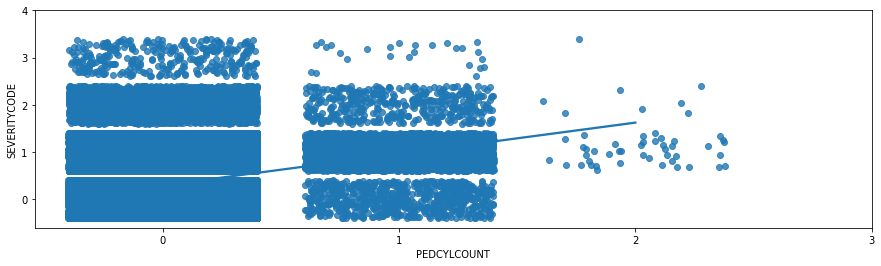

In [125]:
plt.figure(figsize=(15,4))

pcc=sns.regplot(x="PEDCYLCOUNT", y="SEVERITYCODE", data=df_cleaned, x_jitter=.4, y_jitter=.4)
pcc.set(ylim=(None,4), xticks=[0,1,2,3])

<p>The regression line isn't very steep and the data points are very far from the fitted line. Therefore it might not be a reliable variable.</p>

In [126]:
tau, p_value = stats.kendalltau(df_cleaned["PEDCYLCOUNT"], df_cleaned["SEVERITYCODE"])
print(tau)
print(p_value)

0.2223612644246027
0.0


**Conclusion**

<p>Since the p-value is $<$ 0.001, the correlation between PEDCYLCOUNT and SEVERITYCODE is statistically significant, although the linear relationship is weak (~0.222)</p>

***=> PEDCYLCOUNT is not a good predictor of SEVERITYCODE.***

**4 Relationship between SEVERITYCODE and VEHCOUNT**

[(-0.6066691164071432, 4),

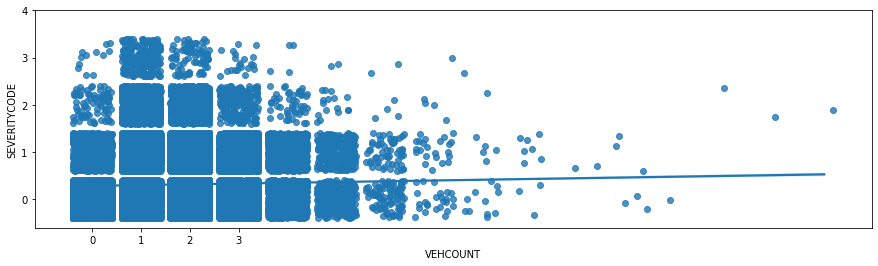

In [127]:
plt.figure(figsize=(15,4))

pcc=sns.regplot(x="VEHCOUNT", y="SEVERITYCODE", data=df_cleaned, x_jitter=.4, y_jitter=.4)
pcc.set(ylim=(None,4),  xticks=[0,1,2,3])

The regression line is almost horizontal and the data points are very far from the fitted line. Therefore it might not be a reliable variable.

In [128]:
tau, p_value = stats.kendalltau(df_cleaned["VEHCOUNT"], df_cleaned["SEVERITYCODE"])
print(tau)
print(p_value)

-0.020767258732977734
5.2700825661091405e-24


**Conclusion**

<p>Since the p-value is $>$ 0.001, the correlation between VEHCOUNT and SEVERITYCODE is statistically significant and the linear relationship is weak (~0.021)</p>

***=> VEHCOUNT is not a good predictor of SEVERITYCODE.***

**5 Relationship between SEVERITYCODE and INJURIES**

[(0, 4), (-4.324134071340906, 20)]

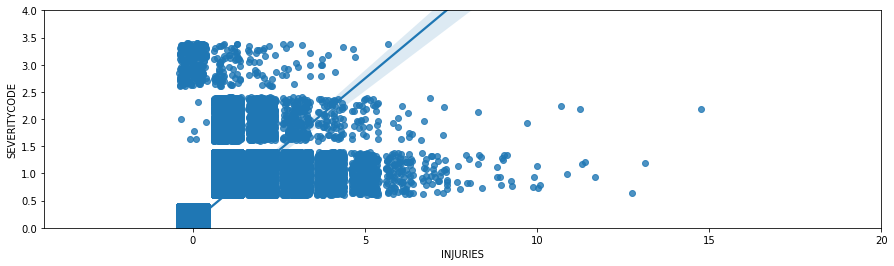

In [176]:
plt.figure(figsize=(15,4))

pcc=sns.regplot(x="INJURIES", y="SEVERITYCODE", data=df_cleaned, x_jitter=.4, y_jitter=.4)
pcc.set(ylim=(0,4), xlim=(None,20))

<p>The regression line is almost a perfect diagonal and the data points are fairly close to the fitted line. Therefore INJURIES does seem to be a reliable variable.</p>

In [130]:
tau, p_value = stats.kendalltau(df_cleaned["INJURIES"], df_cleaned["SEVERITYCODE"])
print(tau)
print(p_value)

0.9488286804868286
0.0


**Conclusion**

<p>Since the p-value is $<$ 0.001, the correlation between INJURIES and SEVERITYCODE is statistically significant and the linear relationship is strong (~0.949)</p>

***=> INJURIES is a good predictor of SEVERITYCODE.***

**6 Relationship between SEVERITYCODE and SERIOUSINJURIES**

[(0, 4)]

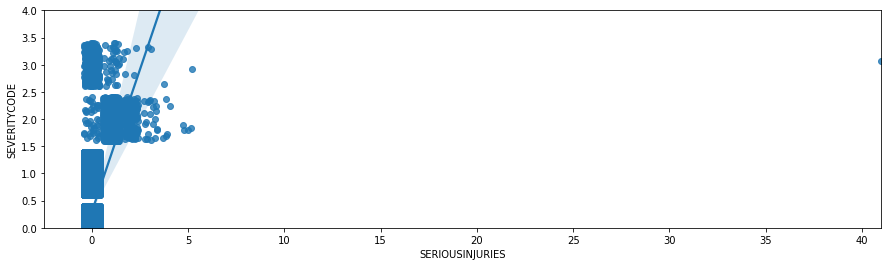

In [131]:
plt.figure(figsize=(15,4))

pcc=sns.regplot(x="SERIOUSINJURIES", y="SEVERITYCODE", data=df_cleaned, x_jitter=.4, y_jitter=.4)
pcc.set(ylim=(0,4))

<p>Even though the regression line is almost a perfect diagonal, the data points are very far from the fitted line. Therefore SERIOUSINJURIES does not seem to be a reliable variable.</p>

In [132]:
tau, p_value = stats.kendalltau(df_cleaned["SERIOUSINJURIES"], df_cleaned["SEVERITYCODE"])
print(tau)
print(p_value)

0.2603408999481954
0.0


**Conclusion**

<p>Since the p-value is $<$ 0.001, the correlation between SERIOUSINJURIES and SEVERITYCODE is statistically significant, but the linear relationship is weak (~0.260)</p>

***=> SERIOUSINJURIES is not a good predictor of SEVERITYCODE.***

**7 Relationship between SEVERITYCODE and FATALITIES**

[(0, 4)]

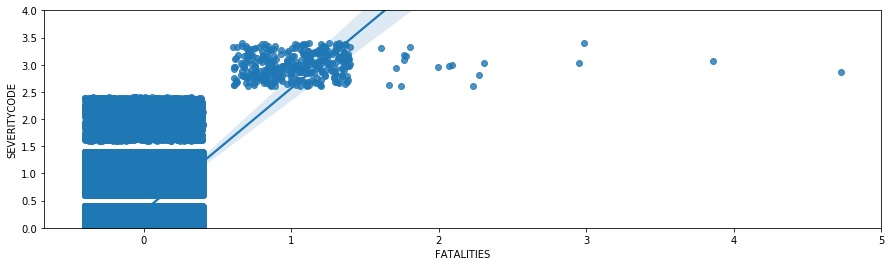

In [133]:
plt.figure(figsize=(15,4))

pcc=sns.regplot(x="FATALITIES", y="SEVERITYCODE", data=df_cleaned, x_jitter=.4, y_jitter=.4)
pcc.set(ylim=(0,4))

<p>Even though the regression line is almost a perfect diagonal, the data points are very far from the fitted line. Therefore FATALITIES does not seem to be a reliable variable.</p>

In [134]:
tau, p_value = stats.kendalltau(df_cleaned["FATALITIES"], df_cleaned["SEVERITYCODE"])
print(tau)
print(p_value)

0.08818087504503065
0.0


**Conclusion**

<p>Since the p-value is $<$ 0.001, the correlation between FATALITIES and SEVERITYCODE is statistically significant, but the linear relationship is weak (~0.088)</p>

***=> FATALITIES is not a good predictor of SEVERITYCODE.***

**Relationship between Severity and the categorical attributes**

A good way to visualize categorical variables and identify their relationship with the label variable is by using boxplots. We will visualize all categorical feature attributes and also look at the frequency of each categorical value of an attribute. This will give us a good idea whether or not an attribute would be a helpful predictor variable.


In total, there are 17 categorical attributes for which we need to explore the relationship to SEVERITYCODE further:
* 1 ADDRTYPE
* 2 COLLISIONTYPE
* 3 JUNCTIONTYPE
* 4 SDOT_COLCODE
* 5 INATTENTIONIND
* 6 UNDERINFL
* 7 WEATHER
* 8 ROADCOND
* 9 LIGHTCOND
* 10 PEDROWNOTGRNT
* 11 SPEEDING
* 12 HITPARKEDCAR
* 13 YEAR
* 14 MONTH
* 15 DAY
* 16 HOUR
* 17 WEEKDAY

**1 Relationship between SEVERITYCODE and ADDRTYPE**

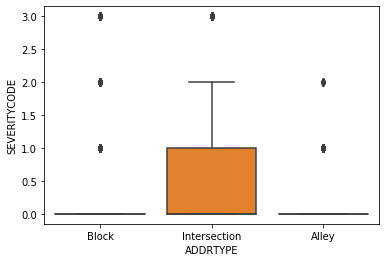

In [172]:
sns.boxplot(x="ADDRTYPE", y="SEVERITYCODE", data=df_cleaned)

In [137]:
ADDRTYPE_counts = df_cleaned['ADDRTYPE'].value_counts().to_frame()
ADDRTYPE_counts.rename(columns={'ADDRTYPE': 'value_counts'}, inplace=True)
ADDRTYPE_counts.index.name = 'ADDRTYPE'
ADDRTYPE_counts

,value_counts
ADDRTYPE,
Block,138848
Intersection,69354
Alley,3910


**Conclusion**

The distribution of SEVERITYCODE between the different ADDRTYPE categories differs and frequency distribution between the categories is acceptable.

***=> ADDRTYPE is a good predictor of SEVERITYCODE.***

**2 Relationship between SEVERITYCODE and COLLISIONTYPE**

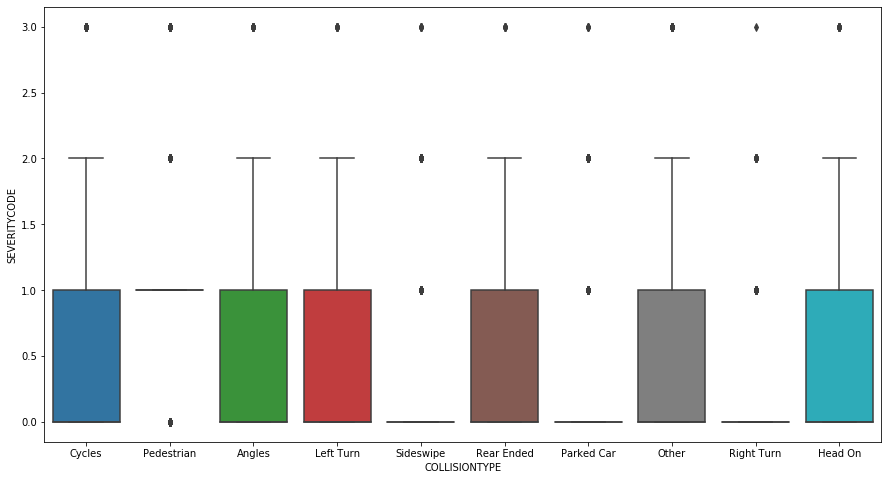

In [138]:
plt.figure(figsize=(15,8))

sns.boxplot(x="COLLISIONTYPE", y="SEVERITYCODE", data=df_cleaned)

In [139]:
COLLISIONTYPE_counts = df_cleaned['COLLISIONTYPE'].value_counts().to_frame()
COLLISIONTYPE_counts.rename(columns={'COLLISIONTYPE': 'value_counts'}, inplace=True)
COLLISIONTYPE_counts.index.name = 'COLLISIONTYPE'
COLLISIONTYPE_counts

,value_counts
COLLISIONTYPE,
Parked Car,48551
Angles,35573
Rear Ended,34691
Other,24588
Cycles,22832
Sideswipe,18891
Left Turn,14115
Pedestrian,7666
Right Turn,3017


**Conclusion**

The distribution of SEVERITYCODE between the different categories of COLLISIONTYPE have significant overlap, but they frequency distribution between the categories is not skewed.

***=> Because of the overlap COLLISIONTYPE is not a good predictor of SEVERITYCODE.***

**3 Relationship between SEVERITYCODE and JUNCTIONTYPE**

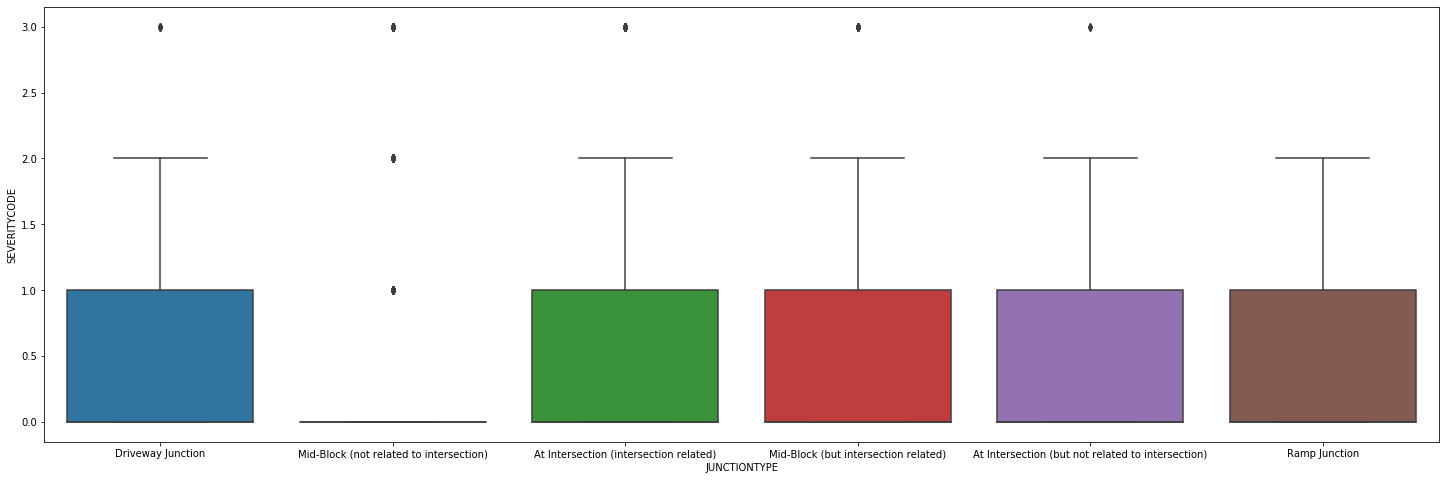

In [82]:
plt.figure(figsize=(25,8))
sns.boxplot(x="JUNCTIONTYPE", y="SEVERITYCODE", data=df_cleaned)

In [140]:
JUNCTIONTYPE_counts = df_cleaned['JUNCTIONTYPE'].value_counts().to_frame()
JUNCTIONTYPE_counts.rename(columns={'JUNCTIONTYPE': 'value_counts'}, inplace=True)
JUNCTIONTYPE_counts.index.name = 'JUNCTIONTYPE'
JUNCTIONTYPE_counts

,value_counts
JUNCTIONTYPE,
Mid-Block (not related to intersection),108450
At Intersection (intersection related),67019
Mid-Block (but intersection related),23305
Driveway Junction,10981
At Intersection (but not related to intersection),2170
Ramp Junction,187


**Conclusion**

The distribution of SEVERITYCODE between the different categories of JUNCTIONTYPE have significant overlap, but they frequency distribution between the categories is not skewed.

***=> Because of the overlap JUNCTIONTYPE is not a good predictor of SEVERITYCODE.***

**4 Relationship between SEVERITYCODE and SDOT_COLCODE**

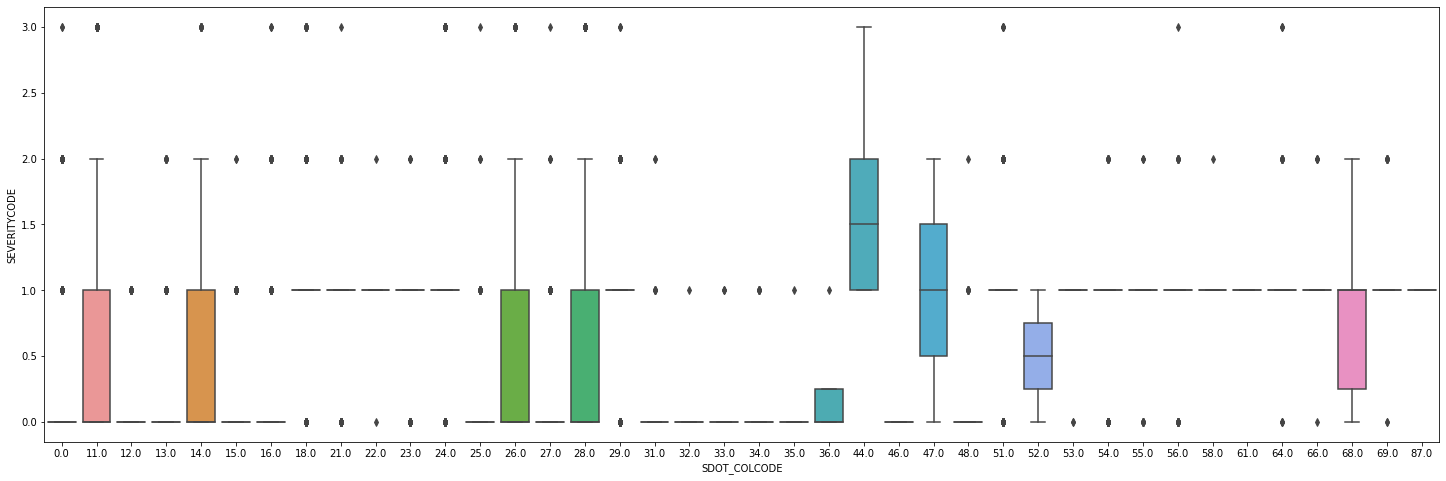

In [141]:
plt.figure(figsize=(25, 8))
sns.boxplot(x="SDOT_COLCODE", y="SEVERITYCODE", data=df_cleaned)

In [142]:
SDOT_COLCODE_counts = df_cleaned['SDOT_COLCODE'].value_counts().to_frame()
SDOT_COLCODE_counts.rename(columns={'SDOT_COLCODE': 'value_counts'}, inplace=True)
SDOT_COLCODE_counts.index.name = 'SDOT_COLCODE'
SDOT_COLCODE_counts

,value_counts
SDOT_COLCODE,
11.0,89084
14.0,57015
0.0,16838
16.0,10274
28.0,9335
24.0,7585
13.0,6605
26.0,4958
18.0,3384


**Conclusion**

We see that the distribution of SEVERITYCODE between the different SDOT_COLCODE categories differs; as such SDOT_COLCODE could potentially be a predictor of SEVERITYCODE. However, looking at the value counts for the individual categories, some of them have a little as 1 value count, so the results are skewed. Thus, we are not able to draw any conclusions about the SDOT_COLCODE.

***=> SDOT_COLCODE is not a good predictor of SEVERITYCODE.***

**5 Relationship between SEVERITYCODE and INATTENTIONIND**

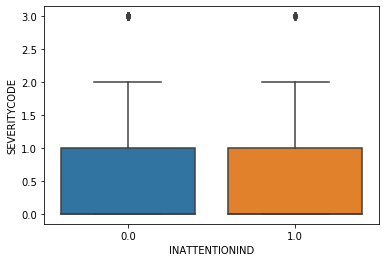

In [144]:
sns.boxplot(x="INATTENTIONIND", y="SEVERITYCODE", data=df_cleaned)

In [143]:
INATTENTIONIND_counts = df_cleaned['INATTENTIONIND'].value_counts().to_frame()
INATTENTIONIND_counts.rename(columns={'INATTENTIONIND': 'value_counts'}, inplace=True)
INATTENTIONIND_counts.index.name = 'INATTENTIONIND'
INATTENTIONIND_counts

,value_counts
INATTENTIONIND,
0.0,181925
1.0,30187


**Conclusion**

The distribution of SEVERITYCODE between the different categories of INATTENTIONIND have significant overlap, but they frequency distribution between the categories is not skewed.

***=> Because of the overlap INATTENTIONIND is not a good predictor of SEVERITYCODE.***

**6 Relationship between SEVERITYCODE and UNDERINFL**

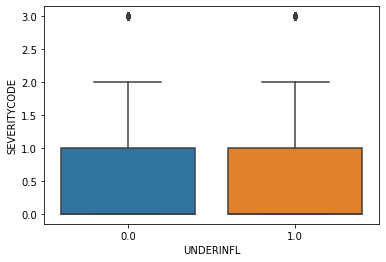

In [146]:
sns.boxplot(x="UNDERINFL", y="SEVERITYCODE", data=df_cleaned)

In [145]:
UNDERINFL_counts = df_cleaned['UNDERINFL'].value_counts().to_frame()
UNDERINFL_counts.rename(columns={'UNDERINFL': 'value_counts'}, inplace=True)
UNDERINFL_counts.index.name = 'UNDERINFL'
UNDERINFL_counts

,value_counts
UNDERINFL,
0.0,202484
1.0,9628


**Conclusion**

The distribution of SEVERITYCODE between the different categories of UNDERINFL have significant overlap, but they frequency distribution between the categories is not skewed.

***=> Because of the overlap UNDERINFL is not a good predictor of SEVERITYCODE.***

**7 Relationship between SEVERITYCODE and WEATHER**

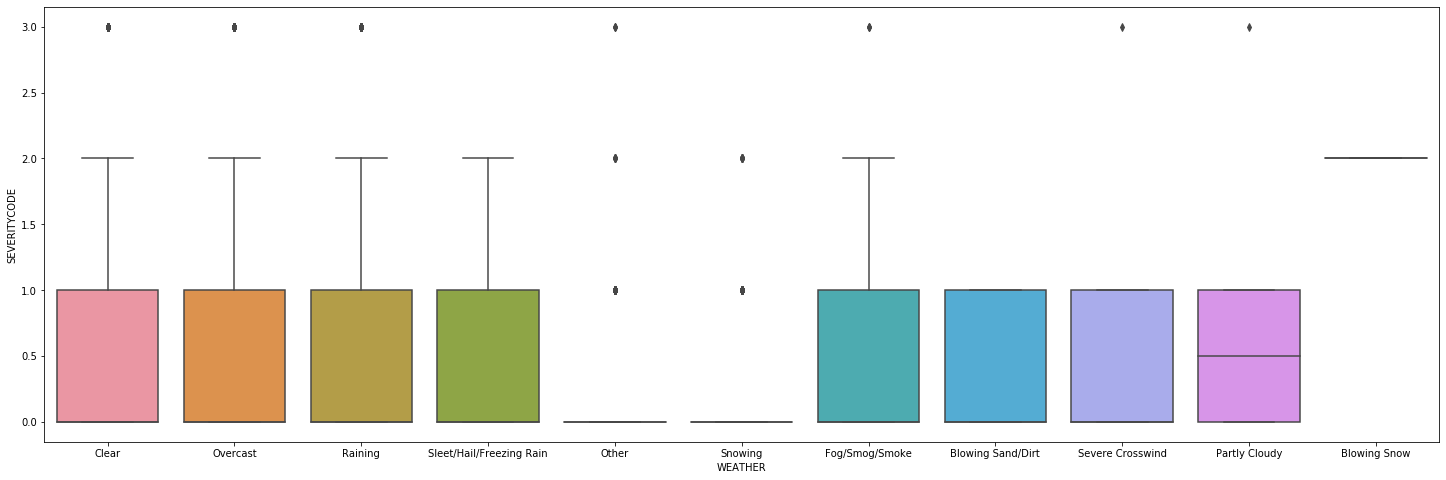

In [147]:
plt.figure(figsize=(25, 8))
sns.boxplot(x="WEATHER", y="SEVERITYCODE", data=df_cleaned)

In [148]:
WEATHER_counts = df_cleaned['WEATHER'].value_counts().to_frame()
WEATHER_counts.rename(columns={'WEATHER': 'value_counts'}, inplace=True)
WEATHER_counts.index.name = 'WEATHER'
WEATHER_counts

,value_counts
WEATHER,
Clear,146973
Raining,34029
Overcast,28545
Snowing,919
Other,860
Fog/Smog/Smoke,577
Sleet/Hail/Freezing Rain,116
Blowing Sand/Dirt,56
Severe Crosswind,26


**Conclusion**

We see that the distribution of SEVERITYCODE between the different WEATHER categories differs; as such WEATHER could potentially be a predictor of SEVERITYCODE. However, looking at the value counts for the individual categories, some of them have a little as 1 value count, so the results are skewed. Thus, we are not able to draw any conclusions about the WEATHER.

***=> WEATHER is not a good predictor of SEVERITYCODE.***

**8 Relationship between SEVERITYCODE and ROADCOND**

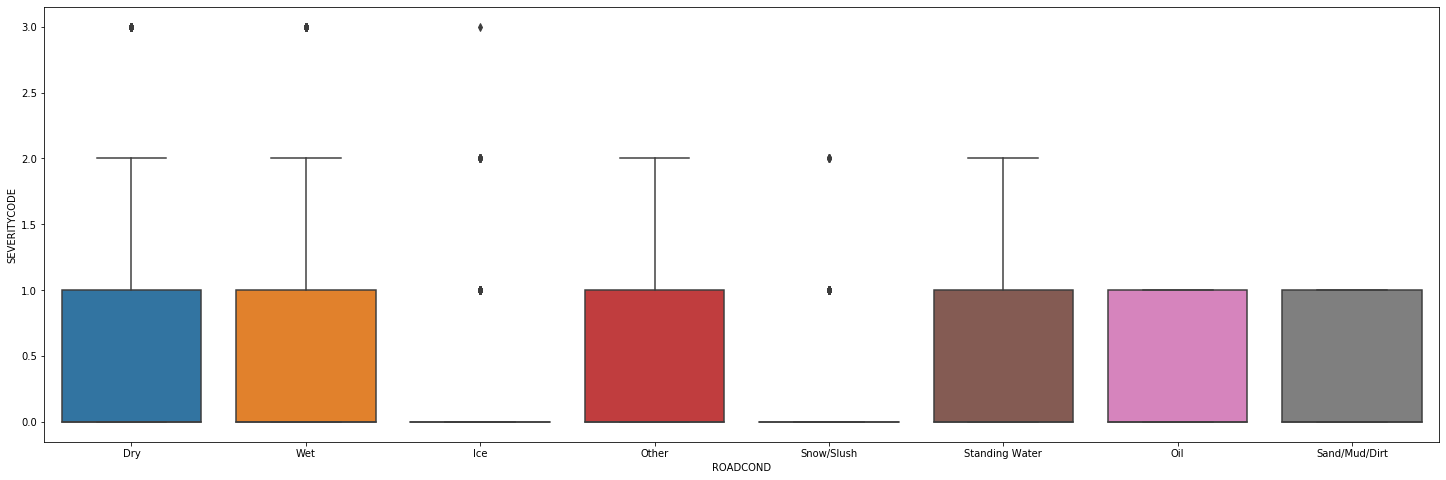

In [149]:
plt.figure(figsize=(25, 8))
sns.boxplot(x="ROADCOND", y="SEVERITYCODE", data=df_cleaned)

In [151]:
ROADCOND_counts = df_cleaned['ROADCOND'].value_counts().to_frame()
ROADCOND_counts.rename(columns={'ROADCOND': 'value_counts'}, inplace=True)
ROADCOND_counts.index.name = 'ROADCOND'
ROADCOND_counts

,value_counts
ROADCOND,
Dry,160748
Wet,48723
Ice,1231
Snow/Slush,1014
Other,136
Standing Water,119
Sand/Mud/Dirt,77
Oil,64


**Conclusion**

The distribution of SEVERITYCODE between the different categories of ROADCOND have significant overlap, but they frequency distribution between the categories is not skewed.

***=> Because of the overlap ROADCOND is not a good predictor of SEVERITYCODE.***

**9 Relationship between SEVERITYCODE and LIGHTCOND**

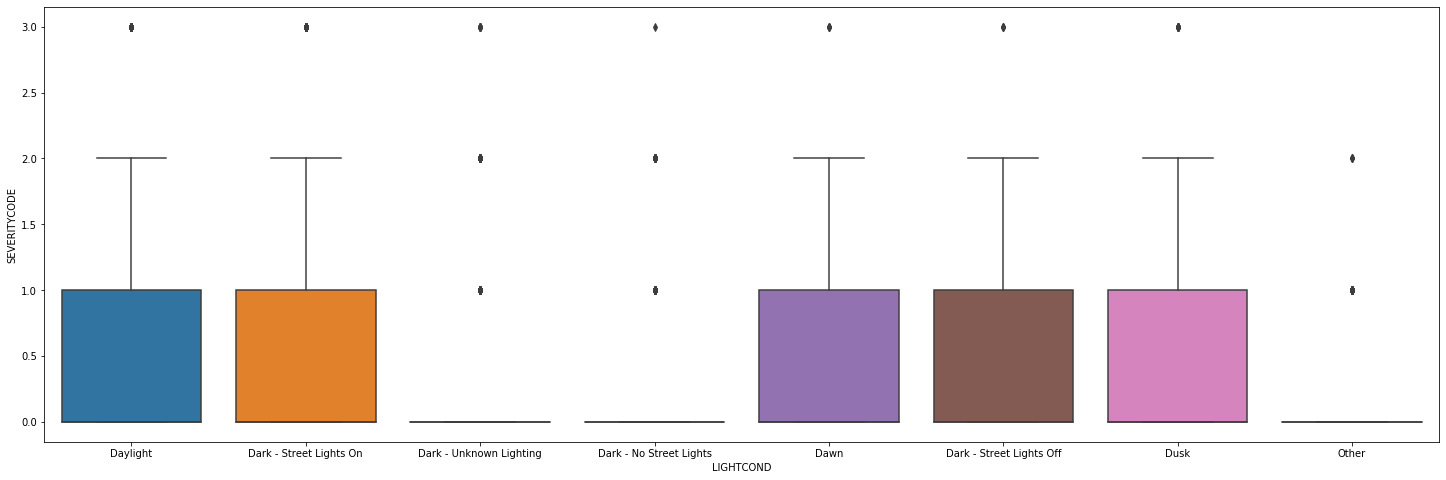

In [152]:
plt.figure(figsize=(25, 8))
sns.boxplot(x="LIGHTCOND", y="SEVERITYCODE", data=df_cleaned)

In [153]:
LIGHTCOND_counts = df_cleaned['LIGHTCOND'].value_counts().to_frame()
LIGHTCOND_counts.rename(columns={'LIGHTCOND': 'value_counts'}, inplace=True)
LIGHTCOND_counts.index.name = 'LIGHTCOND'
LIGHTCOND_counts

,value_counts
LIGHTCOND,
Daylight,127944
Dark - Street Lights On,50130
Dark - Unknown Lighting,22288
Dusk,6081
Dawn,2608
Dark - No Street Lights,1578
Dark - Street Lights Off,1239
Other,244


**Conclusion**

The distribution of SEVERITYCODE between the different categories of LIGHTCOND have significant overlap, but they frequency distribution between the categories is not skewed.

***=> Because of the overlap LIGHTCOND is not a good predictor of SEVERITYCODE.***

**10 Relationship between SEVERITYCODE and PEDROWNOTGRNT**

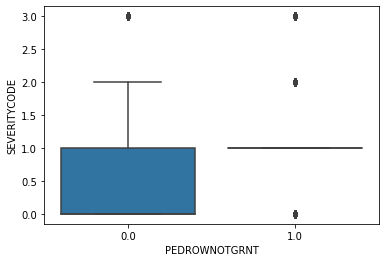

In [154]:
sns.boxplot(x="PEDROWNOTGRNT", y="SEVERITYCODE", data=df_cleaned)

In [155]:
PEDROWNOTGRNT_counts = df_cleaned['PEDROWNOTGRNT'].value_counts().to_frame()
PEDROWNOTGRNT_counts.rename(columns={'PEDROWNOTGRNT': 'value_counts'}, inplace=True)
PEDROWNOTGRNT_counts.index.name = 'PEDROWNOTGRNT'
PEDROWNOTGRNT_counts

,value_counts
PEDROWNOTGRNT,
0.0,206921
1.0,5191


**Conclusion**

The distribution of SEVERITYCODE between the different PEDROWNOTGRNT categories differs and frequency distribution between the categories is acceptable.

***=> PEDROWNOTGRNT is a good predictor of SEVERITYCODE.***

**11 Relationship between SEVERITYCODE and SPEEDING**

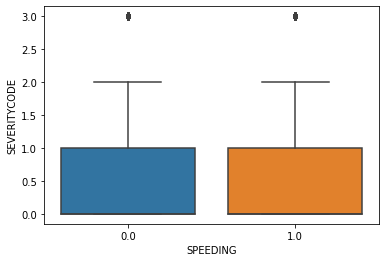

In [156]:
sns.boxplot(x="SPEEDING", y="SEVERITYCODE", data=df_cleaned)

In [157]:
SPEEDING_counts = df_cleaned['SPEEDING'].value_counts().to_frame()
SPEEDING_counts.rename(columns={'SPEEDING': 'value_counts'}, inplace=True)
SPEEDING_counts.index.name = 'SPEEDING'
SPEEDING_counts

,value_counts
SPEEDING,
0.0,202184
1.0,9928


**Conclusion**

The distribution of SEVERITYCODE between the different categories of SPEEDING have significant overlap, but they frequency distribution between the categories is not skewed.

***=> Because of the overlap SPEEDING is not a good predictor of SEVERITYCODE.***

**12 Relationship between SEVERITYCODE and HITPARKEDCAR**

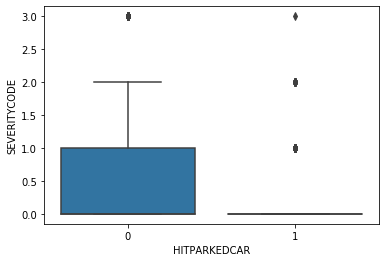

In [158]:
sns.boxplot(x="HITPARKEDCAR", y="SEVERITYCODE", data=df_cleaned)

In [159]:
HITPARKEDCAR_counts = df_cleaned['HITPARKEDCAR'].value_counts().to_frame()
HITPARKEDCAR_counts.rename(columns={'HITPARKEDCAR': 'value_counts'}, inplace=True)
HITPARKEDCAR_counts.index.name = 'HITPARKEDCAR'
HITPARKEDCAR_counts

,value_counts
HITPARKEDCAR,
0,200079
1,12033


**Conclusion**

The distribution of SEVERITYCODE between the different HITPARKEDCAR categories differs and frequency distribution between the categories is acceptable.

***=> HITPARKEDCAR is a good predictor of SEVERITYCODE.***

**13 Relationship between SEVERITYCODE and YEAR**

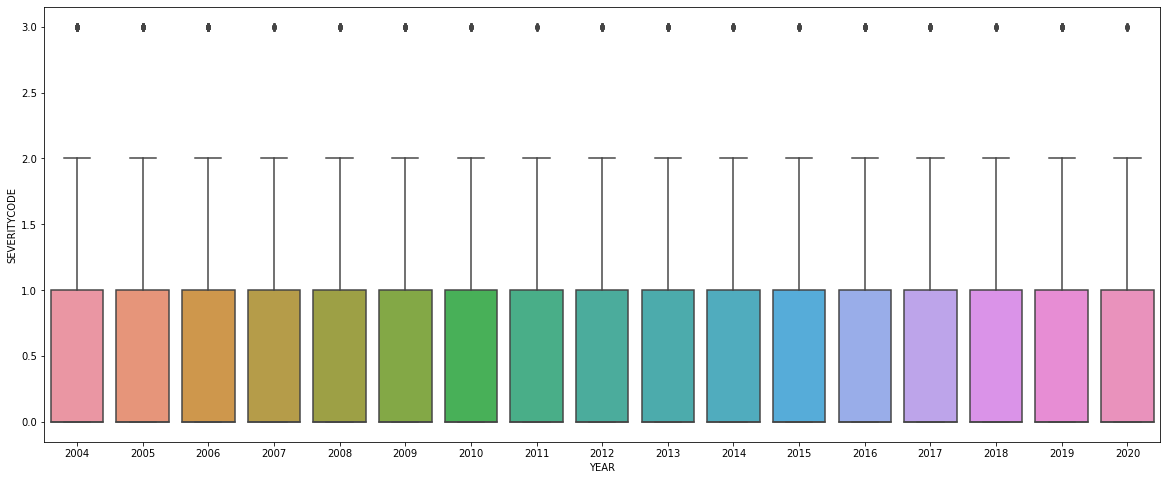

In [160]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="YEAR", y="SEVERITYCODE", data=df_cleaned)

In [161]:
YEAR_counts = df_cleaned['YEAR'].value_counts().to_frame()
YEAR_counts.rename(columns={'YEAR': 'value_counts'}, inplace=True)
YEAR_counts.index.name = 'YEAR'
YEAR_counts

,value_counts
YEAR,
2006,15525
2005,15349
2007,14730
2015,14260
2016,13955
2008,13879
2014,13212
2013,12752
2017,12477


**Conclusion**

The distribution of SEVERITYCODE between the different categories of YEAR have significant overlap, but they frequency distribution between the categories is not overly skewed.

***=> Because of the overlap YEAR is not a good predictor of SEVERITYCODE.***

**14 Relationship between SEVERITYCODE and MONTH**

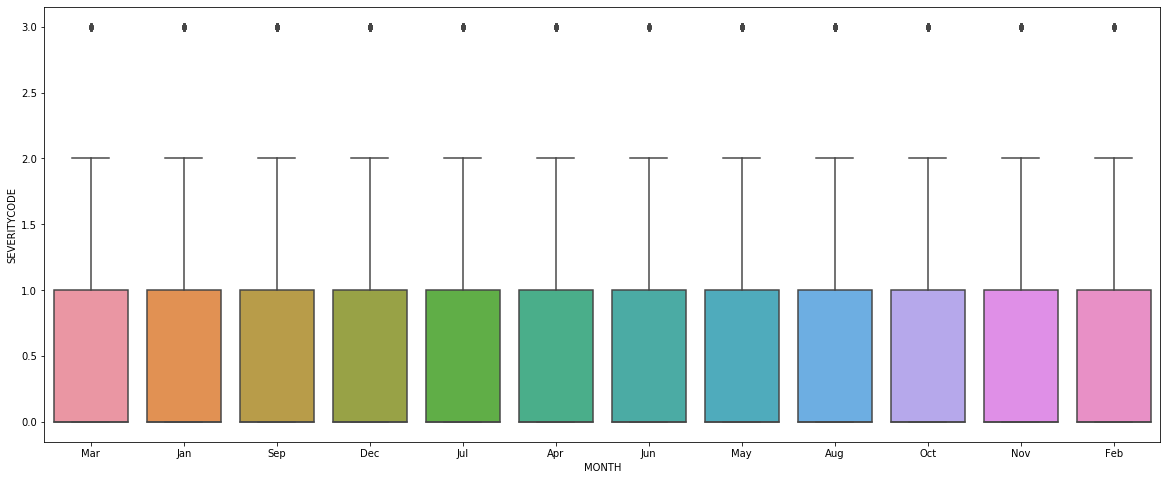

In [162]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="MONTH", y="SEVERITYCODE", data=df_cleaned)

In [163]:
MONTH_counts = df_cleaned['MONTH'].value_counts().to_frame()
MONTH_counts.rename(columns={'MONTH': 'value_counts'}, inplace=True)
MONTH_counts.index.name = 'MONTH'
MONTH_counts

,value_counts
MONTH,
Oct,19155
May,18472
Jun,18379
Jul,18267
Aug,18054
Nov,17850
Jan,17771
Mar,17429
Apr,17315


**Conclusion**

The distribution of SEVERITYCODE between the different categories of MONTH have significant overlap, but they frequency distribution between the categories is not overly skewed.

***=> Because of the overlap MONTH is not a good predictor of SEVERITYCODE.***

**15 Relationship between SEVERITYCODE and DAY**

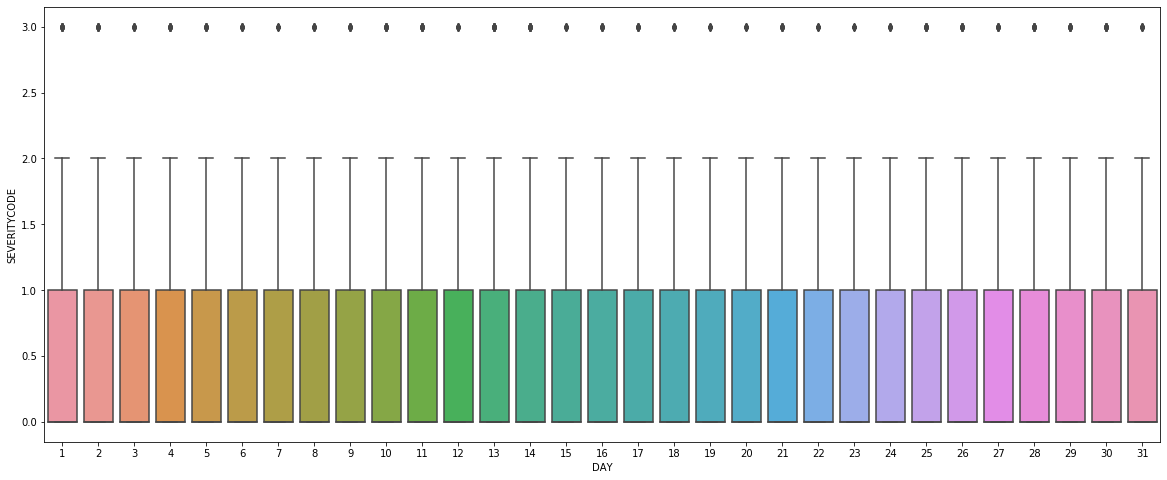

In [164]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="DAY", y="SEVERITYCODE", data=df_cleaned)

In [165]:
DAY_counts = df_cleaned['DAY'].value_counts().to_frame()
DAY_counts.rename(columns={'DAY': 'value_counts'}, inplace=True)
DAY_counts.index.name = 'DAY'
DAY_counts

,value_counts
DAY,
15,7298
1,7224
5,7208
8,7122
13,7107
9,7097
2,7096
10,7075
20,7057


**Conclusion**

The distribution of SEVERITYCODE between the different categories of DAY have significant overlap, but they frequency distribution between the categories is not overly skewed.

***=> Because of the overlap DAY is not a good predictor of SEVERITYCODE.***

**16 Relationship between SEVERITYCODE and HOUR**

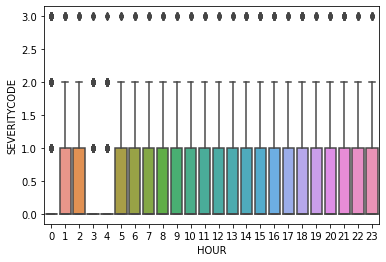

In [166]:
sns.boxplot(x="HOUR", y="SEVERITYCODE", data=df_cleaned)

In [170]:
HOUR_counts = df_cleaned['HOUR'].value_counts().to_frame()
HOUR_counts.rename(columns={'HOUR': 'value_counts'}, inplace=True)
HOUR_counts.index.name = 'HOUR'
HOUR_counts

,value_counts
HOUR,
0,46970
17,13349
16,12473
15,11870
14,10915
12,10679
13,10485
18,10067
8,8785


**Conclusion**

The distribution of SEVERITYCODE between the different categories of HOUR have significant overlap, but they frequency distribution between the categories is not overly skewed.

***=> Because of the overlap HOUR is not a good predictor of SEVERITYCODE.***

**17 Relationship between SEVERITYCODE and WEEKDAY**

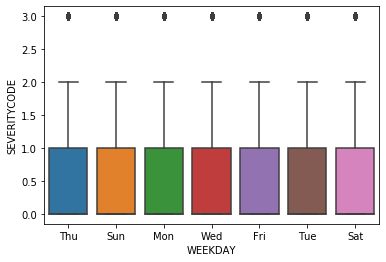

In [168]:
sns.boxplot(x="WEEKDAY", y="SEVERITYCODE", data=df_cleaned)

In [169]:
WEEKDAY_counts = df_cleaned['WEEKDAY'].value_counts().to_frame()
WEEKDAY_counts.rename(columns={'WEEKDAY': 'value_counts'}, inplace=True)
WEEKDAY_counts.index.name = 'WEEKDAY'
WEEKDAY_counts

,value_counts
WEEKDAY,
Fri,34990
Thu,32117
Wed,31422
Tue,31110
Sat,29731
Mon,28811
Sun,23931


**Conclusion**

The distribution of SEVERITYCODE between the different categories of WEEKDAY have significant overlap, but they frequency distribution between the categories is not skewed.

***=> Because of the overlap WEEKDAY is not a good predictor of SEVERITYCODE.***

<h3>Conclusion: Important Attributes</h3>

<p>We now have a better idea of what our data looks like and which variables are important to take into account when predicting the SEVERITYCODE of a collision. We have narrowed it down to the following variables:</p>

Continuous numerical variables:
<ul>
    <li>INJURIES</li>
</ul>
    
Categorical variables:
<ul>
    <li>ADDRTYPE</li>
    <li>PEDROWNOTGRNT</li>
    <li>HITPARKEDCAR</li>
</ul>

This also means we can **drop the following attributes** from our dataset:</p>

Continuous numerical variables:
<ul>
    <li>PERSONCOUNT</li>
    <li>PEDCOUNT</li>
    <li>PEDCYLCOUNT</li>
    <li>VEHCOUNT</li>
    <li>SERIOUSINJURIES</li>
    <li>FATALITIES</li>
</ul>
    
Categorical variables:
<ul>
    <li>COLLISIONTYPE</li>
    <li>JUNCTIONTYPE</li>
    <li>SDOT_COLCODE </li>
    <li>INATTENTIONIND</li>    
    <li>UNDERINFL</li>    
    <li>WEATHER</li>
    <li>ROADCOND</li>
    <li>LIGHTCOND</li>
    <li>SPEEDING</li>
    <li>YEAR</li>
    <li>MONTH</li>
    <li>DAY</li>
    <li>HOUR</li>
    <li>WEEKDAY</li>
</ul>

In [173]:
#drop columns

df_explored=df_cleaned.drop(columns=['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'SERIOUSINJURIES', 'FATALITIES', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'WEEKDAY', 'SDOT_COLCODE'])



## 3.2 Data preparation for Machine Learning

**get_dummies()**

Most ML models do not understand string values, only numbers. That is why we have to translate categorical values into numbers. We do so by using the get_dummies() method. This method assigns a numerical variable to a category of an attribute. They are called 'dummies' because the numbers themselves don't have inherent meaning. 

In [100]:
df_dummy = pd.get_dummies(df_explored)

df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212112 entries, 0 to 221524
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   SEVERITYCODE           212112 non-null  int64  
 1   INJURIES               212112 non-null  int64  
 2   PEDROWNOTGRNT          212112 non-null  float64
 3   HITPARKEDCAR           212112 non-null  int64  
 4   ADDRTYPE_Alley         212112 non-null  uint8  
 5   ADDRTYPE_Block         212112 non-null  uint8  
 6   ADDRTYPE_Intersection  212112 non-null  uint8  
dtypes: float64(1), int64(3), uint8(3)
memory usage: 18.7 MB


In [101]:
df_clean_dummy.head()

,SEVERITYCODE,INJURIES,PEDROWNOTGRNT,HITPARKEDCAR,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection
0,1,1,1.0,0,0,1,0
1,1,1,0.0,0,0,1,0
2,0,0,0.0,0,0,0,1
3,0,0,0.0,0,0,0,1
4,0,0,0.0,0,0,1,0


**Split the data into training and testing data**

An important step in testing a model is to split data into training and testing data. We will put the target data Severity in a separate dataframe and drop price data in another separate x data data frame for our predictor variables.

In [102]:
y_data = df_clean_dummy['SEVERITYCODE']
x_data=df_clean_dummy.drop('SEVERITYCODE',axis=1)

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 31817
number of training samples: 180295


## 3.3 Predictive Modeling

The scope of this Capstone is to create predictions for accident severity using Supervised Machine Learning.

In general, this gives us two algorithm choices: Regression and classification algorithms. So which one would be suitable for our problem at hand?

**Regression algorithms**

In supervised machine learning, regression algorithms attempt to estimate the mapping function from the input variables to numerical or continuous output variables.

With regression algorithms, y is a real value, which can be an integer or a float. 

For example, when provided with a dataset about cars, and you are asked to predict their prices, that is a regression task because price will be a continuous output.

An example of a common regression algorithm would be linear regression.

**Classification algorithms**

In supervised machine learning, classification algorithms attempt to estimate the mapping function from the input variables to discrete or categorical output variables.

With classification algorithms, y is a category that the mapping function predicts. 

For example, when provided with a dataset about cars, a classification algorithm can try to predict whether the prices for the cars sell for a low, high or medium price compared to the recommended retail price. So the price will be classified into three discrete categories

Examples of the common classification algorithms include logistic regression, Naïve Bayes, decision trees, and K Nearest Neighbors.

### Do we have a regression or classification problem?

Even though we are measuring severity using numbers, the problem we are facing can only be identified as a classification problem, because the numerical values are discrete and not continuous.

In order to classify as continuous, data needs to be able to have almost any numeric value and can be meaningfully subdivided into finer and finer increments, depending upon the precision of the measurement system. This is not the case for Severity.

That is why we will focus on the most common classification algorithms for our problem: Naive Bayes, Logistic Regression, K-nearest neighbors and decision trees.

In [163]:
#List of classification algorithms
list_alg=['Naive Bayes','Logistic Regression','K-nearest Neighbors','Decision Trees']

#List of model metrics
list_metric=['Accuracy Score','Logistic Loss']

# Initialize an empty list for the accuracy score for each algorithm
accuracy_lst=[]

# Initialize an empty list for the log loss for each algorithm
log_loss_lst=[]

### Algorithm 1: Naive Bayes

In [167]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(x_train, y_train)

#Predict the response for test dataset
y_hat = gnb.predict(x_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_hat)

# Append to the accuracy list
accuracy_lst.append(acc)

# Get the log loss
gnb_probas = gnb.predict_proba(x_test)
gnb_log_loss = log_loss(y_test, gnb_probas)

# Append to the log loss list
log_loss_lst.append(gnb_log_loss)


print("[Naive Bayes] accuracy_score: {:.3f}.".format(acc))
print("[Naive Bayes] log_loss: {:.3f}.".format(gnb_log_loss))


[Naive Bayes] accuracy_score: 0.707.
[Naive Bayes] log_loss: 0.730.


### Algorithm 2: Logistic regression

In [168]:
# Logistic regression
logr = LogisticRegression(random_state=0)
logr.fit(x_train,y_train)
y_hat =logr.predict(x_test)

# Model Accuracy, how often is the classifier correct?
#print("Accuracy:",metrics.accuracy_score(y_test, y_hat))

# Get the accuracy score
acc=accuracy_score(y_test, y_hat)

# Append to the accuracy list
accuracy_lst.append(acc)

# Get the log loss
logr_probas = logr.predict_proba(x_test)
logr_log_loss = log_loss(y_test, logr_probas)

# Append to the log loss list
log_loss_lst.append(logr_log_loss)



print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))
print("[Logistic regression algorithm] log_loss: {:.3f}.".format(logr_log_loss))




[Logistic regression algorithm] accuracy_score: 0.983.
[Logistic regression algorithm] log_loss: 0.074.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Algorithm 3: K-Nearest Neighbors (KNN)

In [169]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(x_train,y_train)

# Predict the labels for the training data X
y_hat = knn.predict(x_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_hat)

# Append to the accuracy list
accuracy_lst.append(acc)

# Get the log loss
knn_probas = knn.predict_proba(x_test)
knn_log_loss = log_loss(y_test, knn_probas)

# Append to the log loss list
log_loss_lst.append(knn_log_loss)



print("[KNN] accuracy_score: {:.3f}.".format(acc))
print("[KNN] log_loss: {:.3f}.".format(knn_log_loss))




[KNN] accuracy_score: 0.983.
[KNN] log_loss: 0.367.


### Algorithm 4: Decision Tree

In [170]:
# Decision tree algorithm

# Instantiate dt
dt = DecisionTreeClassifier(max_depth=8, random_state=1)

# Fit dt to the training set
dt.fit(x_train, y_train)

# Use dt to predict test set labels
y_hat= dt.predict(x_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_hat)

# Append to the accuracy list
accuracy_lst.append(acc)

# Get the log loss
dt_probas = dt.predict_proba(x_test)
dt_log_loss = log_loss(y_test, dt_probas)

# Append to the log loss list
log_loss_lst.append(dt_log_loss)


print("[Decision tree] accuracy_score: {:.3f}.".format(acc))
print("[Decision tree] log_loss: {:.3f}.".format(dt_log_loss))



[Decision tree] accuracy_score: 0.983.
[Decision tree] log_loss: 0.072.


### Accuracy scores and logistic loss for each algorithm

In [172]:
# Calling DataFrame constructor after zipping accuracy score and log_loss lists, with columns specified for each algorithm
df_metric = pd.DataFrame(list(zip(accuracy_lst, log_loss_lst)), columns =list_metric, index=list_alg) 
df_metric 

,Accuracy Score,Logistic Loss
Naive Bayes,0.706855,0.729693
Logistic Regression,0.983028,0.074322
K-nearest Neighbors,0.983028,0.366560
Decision Trees,0.983028,0.071877
